In [1]:
import torch
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torchvision.models as models
from torchvision.models import ResNet50_Weights
from torchvision import transforms
# Option 1: ResNet50 (Recommended for deepfake detection)
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(ResNet50Classifier, self).__init__()
        if pretrained:
            self.backbone = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        else:
            self.backbone = models.resnet50(weights=None)
        
        # Replace the final fully connected layer
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

#Model config
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)


num_classes = 2
img_size = 224
base_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])


print(f"Using {device} device")
model = ResNet50Classifier(num_classes=num_classes, pretrained=False)
model.to(device)
checkpoint = torch.load("cifake_resNet_98.45.pth")

model.load_state_dict(checkpoint)
_ = model.eval()




Using cuda device


### LOAD TEST DATASET

In [2]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader


test_dir = r"C:\Users\dmin\HUST\20242\Image-Deepfake-Detection-Training\cifake\test"


base_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])
val_dataset = datasets.ImageFolder(root=test_dir, transform=base_transform)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
print(f"Validation samples: {len(val_dataset)}")

Validation samples: 20000


Classification Report:
              precision    recall  f1-score   support

        FAKE       0.98      0.99      0.98     10000
        REAL       0.99      0.98      0.98     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000



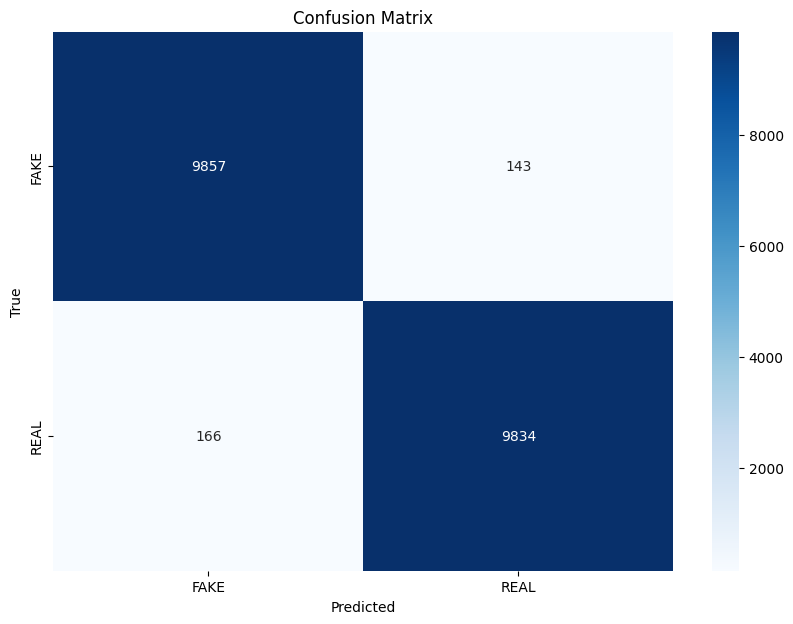

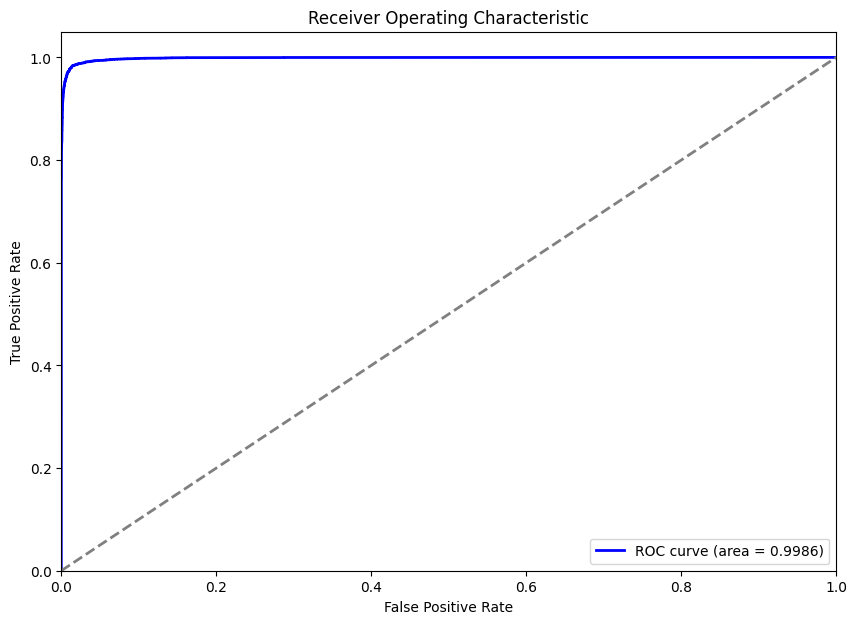

AUC: 0.9986
Accuracy: 0.9846


In [3]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

all_preds = []
all_labels = []
all_probs = []

#Run predictions 
with torch.no_grad():
    for images, labels in val_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        _, preds = torch.max(outputs, 1)

        probs = F.softmax(outputs, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:,1].cpu().numpy()) 

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

#confusion matrix
cm = confusion_matrix(all_labels, all_preds)

#classification report (precision, recall, f1-score)
class_names = val_dataset.classes
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

#Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#ROC curve and AUC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

#Plot ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#AUC value
print(f"AUC: {roc_auc:.4f}")

#accuracy
accuracy = (all_preds == all_labels).sum() / len(all_labels)
print(f"Accuracy: {accuracy:.4f}")